In [21]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_path = '/Qwen/Qwen2___5-1___5B-Instruct'
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
prompt = "北京奥运会"
model_inputs = tokenizer(f'user: {prompt}\n'.strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
inputs_len = len(model_inputs['input_ids'][0])
generated_ids = model.generate(**model_inputs, max_new_tokens=5096)
response = tokenizer.decode(generated_ids[0][inputs_len:], skip_special_tokens=True)
print(response)

中国的北京成功举办了一届非常成功的夏季奥运会，这是中国体育史上的一次重大突破。北京奥运会于2008年8月8日至24日举行，共有来自全球105个国家和地区的运动员参加比赛。北京奥运会的举办不仅展示了中国的经济、文化和科技实力，也提升了中国的国际地位和影响力。它是一场盛大的体育盛会，也是对世界的一次重要交流与展示。

在北京奥运会上，中国代表团取得了优异的成绩，共获得51枚金牌、21枚银牌和28枚铜牌，位列奖牌榜首位。这一成绩不仅为国家赢得了荣誉，也为中国人民树立了信心，体现了中国在体育领域的巨大进步和强大实力。

北京奥运会的成功举办对于推动我国体育事业发展、提升国民健康水平以及促进国际合作都起到了积极的作用。同时，这也成为连接不同文化背景人群的一个桥梁，促进了世界的和平与发展。总之，北京奥运会是中国乃至全世界的一件大事，它的成功举办对中国乃至世界都有着深远的影响。


In [23]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qw

In [3]:
from datasets import load_dataset
ds = load_dataset('json', data_files="/alapca_data_zh/alpaca_gpt4_data_zh.json")
print(ds)
print(ds.column_names)
print(ds['train'][1])

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 48818
    })
})
{'train': ['instruction', 'input', 'output']}
{'instruction': '三原色是什么？', 'input': '', 'output': '三原色通常指的是红色、绿色和蓝色（RGB）。它们是通过加色混合原理创建色彩的三种基础颜色。在以发光为基础的显示设备中（如电视、计算机显示器、智能手机和平板电脑显示屏）, 三原色可混合产生大量色彩。其中红色和绿色可以混合生成黄色，红色和蓝色可以混合生成品红色，蓝色和绿色可以混合生成青色。当红色、绿色和蓝色按相等比例混合时，可以产生白色或灰色。\n\n此外，在印刷和绘画中，三原色指的是以颜料为基础的红、黄和蓝颜色（RYB）。这三种颜色用以通过减色混合原理来创建色彩。不过，三原色的具体定义并不唯一，不同的颜色系统可能会采用不同的三原色。'}


In [4]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }
tokenized_ds = ds['train'].map(process_func)
tokenized_ds

Dataset({
    features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 48818
})

In [5]:
from peft import PromptTuningConfig, get_peft_model, TaskType, PromptTuningInit

# Soft Prompt
# config = PromptTuningConfig(task_type=TaskType.CAUSAL_LM, num_virtual_tokens=10)
# config
# Hard Prompt
config = PromptTuningConfig(task_type=TaskType.CAUSAL_LM,
                            prompt_tuning_init=PromptTuningInit.TEXT,
                            prompt_tuning_init_text="下面是一段人与机器人的对话。",
                            num_virtual_tokens=len(tokenizer("下面是一段人与机器人的对话。")["input_ids"]),
                            tokenizer_name_or_path="/Qwen/Qwen2___5-1___5B-Instruct")
# config

PromptTuningConfig(peft_type=<PeftType.PROMPT_TUNING: 'PROMPT_TUNING'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, num_virtual_tokens=10, token_dim=None, num_transformer_submodules=None, num_attention_heads=None, num_layers=None, prompt_tuning_init=<PromptTuningInit.RANDOM: 'RANDOM'>, prompt_tuning_init_text=None, tokenizer_name_or_path=None, tokenizer_kwargs=None)

In [6]:
model = get_peft_model(model, config)
model

PeftModelForCausalLM(
  (base_model): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151936, 1536)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2SdpaAttention(
            (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
            (k_proj): Linear(in_features=1536, out_features=256, bias=True)
            (v_proj): Linear(in_features=1536, out_features=256, bias=True)
            (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
            (rotary_emb): Qwen2RotaryEmbedding()
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
            (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
            (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
          (post_attenti

In [7]:
model.print_trainable_parameters()

trainable params: 15,360 || all params: 1,543,729,664 || trainable%: 0.0010


In [11]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer
args = TrainingArguments(
    output_dir="./prompt_tuning_output",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1,
    save_steps=20,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [13]:
trainer.train()  

Step,Training Loss
10,2.793000
20,2.761700
30,2.723100
40,2.714400
50,2.740100
60,2.633000
70,2.621700
80,2.620100
90,2.620400
100,2.572800


/data01/tqbian/miniconda3/envs/chatchat/lib/python3.9/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /data01/tqbian/modelPATH/Qwen/Qwen2___5-1___5B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/data01/tqbian/miniconda3/envs/chatchat/lib/python3.9/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /data01/tqbian/modelPATH/Qwen/Qwen2___5-1___5B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/data01/tqbian/miniconda3/envs/chatchat/lib/python3.9/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /data01/tqbian/modelPATH/Qwen/Qwen2___5-1___5B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/data01/tqbian/miniconda3/envs/chatchat/lib/python3.9/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /data01/tqbian/modelPATH/Qwen/Qwen2___5-1

TrainOutput(global_step=381, training_loss=2.4507072898033724, metrics={'train_runtime': 794.3198, 'train_samples_per_second': 61.459, 'train_steps_per_second': 0.48, 'total_flos': 9.782885572809523e+16, 'train_loss': 2.4507072898033724, 'epoch': 0.9986893840104849})

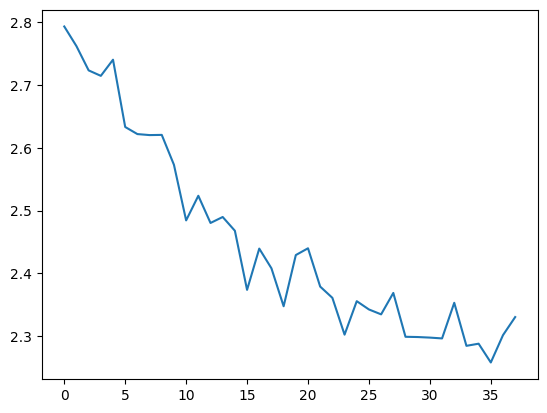

In [14]:
import matplotlib.pyplot as plt
log_history = trainer.state.log_history
losses = [entry["loss"] for entry in log_history if "loss" in entry]
plt.plot(losses)